# Estimate photometric accuracy using an AAVSO standard star cluster

### Check measured magnitudes against aavso star charts

In [9]:
import requests, math
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
%matplotlib inline
plt.style.use('seaborn')

def get_comp_stars(ra,dec,filter_band='V',field_of_view=18.5):
    result = []
    vsp_template = 'https://www.aavso.org/apps/vsp/api/chart/?format=json&fov={}&maglimit=18.5&ra={}&dec={}'
    r = requests.get(vsp_template.format(field_of_view, ra, dec))
    print('Downloaded Comparison Star Chart ID {}'.format(r.json()['chartid']))
    for star in r.json()['photometry']:
        comparison = {}
        comparison['auid'] = star['auid']
        comparison['ra'] = star['ra']
        comparison['dec'] = star['dec']
        for band in star['bands']:
            if band['band'] == filter_band:
                comparison['vmag'] = band['mag']
                comparison['error'] = band['error']
        result.append(comparison)
    return result

In [11]:
# TARGET is NGC7790 from the AAVSO standard star fields list
# https://www.aavso.org/sites/default/files/publications_files/ccd_photometry_guide/CCDPhotometryGuide.pdf

TARGET_RA = '23:58:23'
TARGET_DEC = '61:12:25'
#FITS_DATA_FILE = '/media/dokeeffe/My Passport Ultra/astronomy/CalibratedLight//2016/2016-09-01/2016-09-01-00-15-38NGC7790_Light_15_secs_005.fits'
FITS_DATA_FILE = '/media/dokeeffe/My Passport Ultra/astronomy/CalibratedLight//2016/2016-09-01/2016-09-01-00-11-53NGC7790_Light_15_secs_002.fits'

# Source detection and photometry settings
FWHM = 3.0
SOURCE_SNR = 20
APERTURE_RADIUS = 4.0

comp_stars = get_comp_stars(TARGET_RA, TARGET_DEC)


Downloaded Comparison Star Chart ID X17325AIB


### Load the image from the fits file and detect all sources using photutils

This image has also been plate solved so grab the WCS for later use to convert the x,y coordinates to RA,DEC

In [12]:
hdulist = fits.open(FITS_DATA_FILE)
data = hdulist[0].data.astype(float)
wcs = WCS(hdulist[0].header)
bkg_sigma = mad_std(data)    
daofind = DAOStarFinder(fwhm=FWHM, threshold=SOURCE_SNR*bkg_sigma)    
sources = daofind(data)
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1093.06494339,1.17239829196,0.652671000594,0.176233782899,-0.0105970919381,25.0,0.0,940.738219521,1.21972879934,-0.215658195452
2,562.561604112,3.31100042358,0.533409685053,0.448346583447,-0.154805210743,25.0,0.0,1713.57588286,2.33664604098,-0.921482324313
3,572.25092494,2.52480008387,0.590895732626,-0.0498417604798,0.0216700619036,25.0,0.0,63332.1097889,83.9698568381,-4.81030853187
4,709.280410294,7.12467942308,0.708719261371,0.338843428421,-0.0883160548058,25.0,0.0,2499.41795147,3.13628236476,-1.24103789008
5,798.555324851,7.01064937146,0.706347304206,0.0284258850387,-0.253239530155,25.0,0.0,1342.21381758,1.64943103024,-0.543335401382
6,1050.78464308,15.7535226467,0.774645363987,0.279563120651,-0.0531141348077,25.0,0.0,1050.54687686,1.22897343036,-0.223856234533
7,640.364111675,16.7374404265,0.761978779246,-0.165569701756,-0.10119165616,25.0,0.0,2231.45646576,2.62059345211,-1.04599912886
8,1300.16354876,16.3000888355,0.683419577168,0.130585211817,0.277220965949,25.0,0.0,1102.47963502,1.2835302697,-0.271015287909
9,698.715729975,21.1424105224,0.712659978536,0.118115931348,-0.0282058064983,25.0,0.0,8256.10688761,10.3385731927,-2.5361515168


### Now perform apperture photometry using photutils

In [13]:
positions = (sources['xcentroid'], sources['ycentroid'])    
apertures = CircularAperture(positions, r=APERTURE_RADIUS)    
phot_table = aperture_photometry(data, apertures)    
print(phot_table)   

 id      xcenter            ycenter        aperture_sum
           pix                pix                      
--- ------------------ ------------------ -------------
  1 1093.0649433919275 1.1723982919580722 5081.30867391
  2  562.5616041123209 3.3110004235828434 13224.8264691
  3  572.2509249402151 2.5248000838705766 391151.625694
  4   709.280410293802  7.124679423082443 12247.1172435
  5  798.5553248510611  7.010649371457916 7621.70912195
  6 1050.7846430755758 15.753522646682699 4641.98130546
  7  640.3641116748641 16.737440426477853  10748.705461
  8 1300.1635487597516  16.30008883550914 8265.26927658
  9  698.7157299751524 21.142410522409307 38545.2523797
 10 1377.9838512579172 20.975045676827285 14579.5909088
...                ...                ...           ...
612 295.06531187857087 1234.2898454672656 101754.428382
613   267.072834438199 1238.9786583721784 14420.9869125
614 1219.3135582997734 1237.7792707711224 41008.2373521
615  744.4781710539523 1238.7023517481803  32467

### Now we need to start using this data with the comparison star's data.

The phot_table above contains the fluxes for all detected sources in the image. However we are only interested in the handful of comparison stars and our target star.

First get the x-y pixel coordinates of our target star from the ra-dec position using the image's wcs.

In [14]:
target = SkyCoord(TARGET_RA, TARGET_DEC, unit=(u.hourangle, u.deg))
target_xy = SkyCoord.to_pixel(target, wcs=wcs, origin=1)
target_xy

(array(763.8251617831467), array(640.912492171552))

### Join our photometric measurements table with the list of comparison stars

Now for each comparison star find the corresponding source in the image by finding the closest detetected source.
Closest to +- 3 pixels. We will also add our target star into the results. It will be the only one in the results table which is missing the magnitude **vmag**. We will determine this later

In [15]:
comp_stars.append({'auid': 'target', 'ra': TARGET_RA, 'dec': TARGET_DEC})

for comp_star in comp_stars:
    comp_coord = SkyCoord(comp_star['ra'],comp_star['dec'], unit=(u.hourangle, u.deg))
    xy = SkyCoord.to_pixel(comp_coord, wcs=wcs, origin=1)
    x = xy[0].item(0)
    y = xy[1].item(0)
    for phot_measurement in phot_table:
        if(phot_measurement['xcenter'].value-4 < x < phot_measurement['xcenter'].value+4) and phot_measurement['ycenter'].value-4 < y < phot_measurement['ycenter'].value+4:
            comp_star['x'] = x
            comp_star['y'] = y
            comp_star['measured_flux'] = phot_measurement['aperture_sum']
            if not math.isnan(phot_measurement['aperture_sum']):
                comp_star['measured_instrumental_mag'] = -2.5 * math.log10(phot_measurement['aperture_sum'])
    
results = pd.DataFrame(comp_stars)
results

,auid,dec,error,measured_flux,measured_instrumental_mag,ra,vmag,x,y
0,000-BFX-116,61:19:19.5,0.026,221233.095642,-13.362125,23:58:38.21,11.017,884.775803,975.195048
1,000-BFX-117,61:03:11.5,0.024,194264.305201,-13.220983,23:57:40.22,11.211,466.564789,206.921325
2,000-BFX-118,61:19:44.3,0.078,127505.150149,-12.763819,23:57:49.15,11.659,595.002626,1021.842238
3,000-BFX-119,61:06:24.5,0.017,97749.299702,-12.475284,23:57:27.77,11.944,406.716667,373.300379
4,000-BFX-121,61:11:36.9,0.024,82176.926281,-12.286875,23:58:17.45,12.117,727.151815,604.146848
5,000-BFX-120,61:19:08.8,0.041,75092.837054,-12.188996,23:57:35.15,12.244,509.111391,1000.199589
6,000-BFX-122,61:18:36.0,0.039,63551.194590,-12.007809,23:57:09.54,12.409,354.369557,987.353466
7,000-BFX-123,61:08:14.1,0.027,60383.423684,-11.952294,23:58:03.11,12.452,626.404154,444.355456
8,000-BFX-124,61:10:36.0,0.029,52192.361901,-11.794017,23:58:13.76,12.617,700.609987,555.821437
9,000-BFX-125,61:09:17.1,0.017,44443.854200,-11.619529,23:59:14.06,12.806,1055.240023,458.932335


### Plot the image data

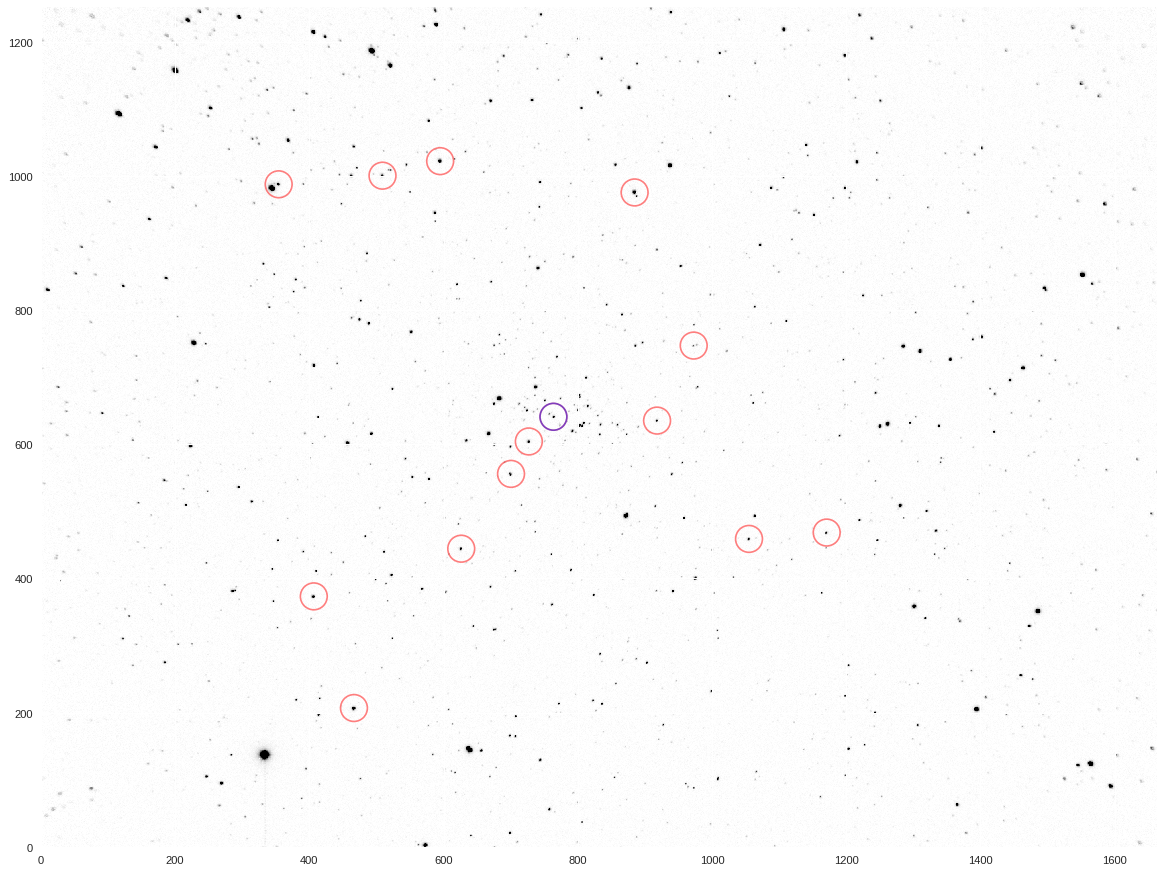

In [16]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
positions = (results['x'], results['y'])    
position_apps = CircularAperture(positions, r=20.)    
target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
position_apps.plot(color='red', lw=1.5, alpha=0.5)
target_app.plot(color='blue', lw=1.5, alpha=0.5)

### Plot the AAVSO magnitude against our measured instrumental magnitude

This should be linear. We will also fit the data using a linear fit function so that the magnitude of the target can be determined.

(10.016999999999999, 15.467000000000001)

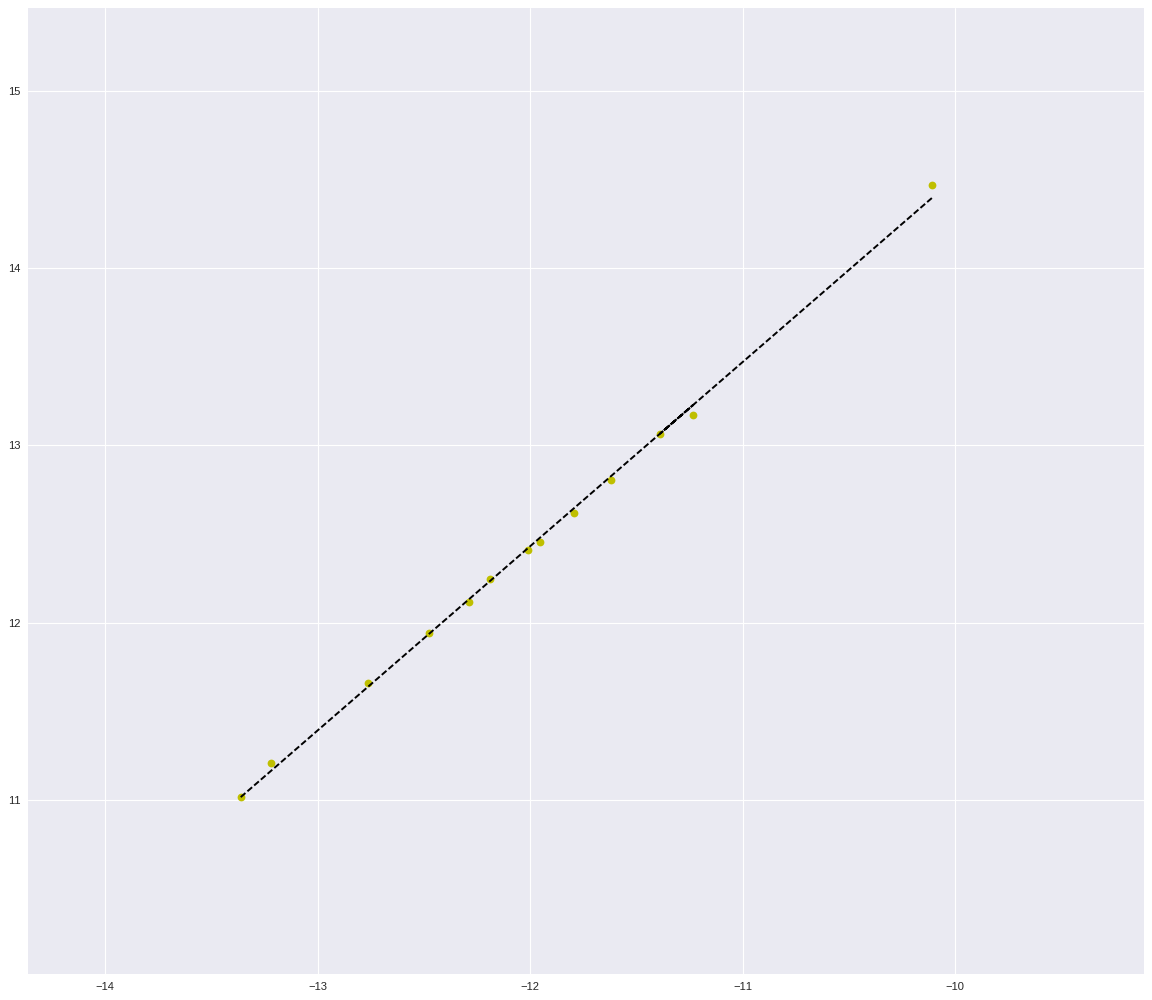

In [17]:
to_plot = results.query('vmag > -9999 and measured_flux > 0')
x = to_plot['measured_instrumental_mag'].values
y = to_plot['vmag'].values
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.plot(target_xy)
plt.xlim(np.min(x)-1, np.max(x)+1)
plt.ylim(np.min(y)-1, np.max(y)+1)
